# The Math Of Mortgages

The advice I get about home buying is at best confusing and at worst contradictory, but always adamant: buy!! This notebook is my attempt to math out home economics, and share it with people. 

In [13]:
%matplotlib inline

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import numpy_financial as npf


def thousands_formatter(x, pos):
    return f"{x/1000}"


month_number_label = "Month Number"

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [15]:
years_to_model = 30
rent_increase_per_year_pct = 2

## My current situation

I live in a 3br and pay $1100/month for a bed with en suite bath.  Let's model that.

<Figure size 432x288 with 0 Axes>

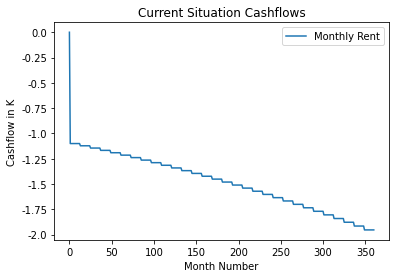

In [16]:
title = "Current Situation"
rent = -1100
rents = [0]
for year in range(years_to_model):
    for month in range(12):
        rents.append(rent)
    rent *= 1 + rent_increase_per_year_pct / 100

plt.figure()

current_df = pd.DataFrame({"Monthly Rent": rents})

ax = current_df.plot(
    xlabel=month_number_label, ylabel="Cashflow in K", title=f"{title} Cashflows"
)
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

I am losing money every month!  Seems bad.  Let's contrast with buying a place.  How about [this one](https://www.redfin.com/DC/Washington/2001-12th-St-NW-20009/unit-210/home/10183145)?

![Condo!](img/Condo1.png)
![Condo payments](img/condo1payment.png)


It's cute!  Small, but accessible as a starter place.  What is it like to put 20% down and own it?

Text(0.5, 1.0, 'Tiny Condo Monthly Cashflows By Component')

<Figure size 432x288 with 0 Axes>

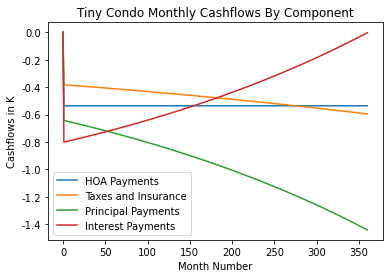

In [27]:
title = "Tiny Condo"
home_value = 445000
pct_down = 20
interest_rate_pct = 2.7
mortgage_amount = home_value * (100 - pct_down) / 100
hoa = -536
# home_appreciation_rate_pct = 3
home_monthly_appreciation_rate_pct = 0.1233

hoas, t_and_i, home_values, down_payments = (
    [0],
    [0],
    [445000],
    [-home_value * pct_down / 100],
)
for year in range(years_to_model):
    for month in range(12):
        hoas.append(hoa)

        home_value *= (100 + home_monthly_appreciation_rate_pct) / 100
        home_values.append(home_value)

        #       This is 382/445000, to get t&i as a fraction of home value.
        t_and_i.append(-0.0008584269662921349 * home_value)

        down_payments.append(0)

periods = np.arange(1 * 12 * years_to_model) + 1
interest_payments = [0]
interest_payments.extend(
    npf.ipmt(
        interest_rate_pct / 100 / 12, periods, 12 * years_to_model, mortgage_amount
    )
)
principal_payments = [0]
principal_payments.extend(
    npf.ppmt(
        interest_rate_pct / 100 / 12, periods, 12 * years_to_model, mortgage_amount
    )
)

first_condo_df = pd.DataFrame(
    {
        "HOA Payments": hoas,
        "Taxes and Insurance": t_and_i,
        "Principal Payments": principal_payments,
        "Interest Payments": interest_payments,
    }
)
plt.figure()
ax = first_condo_df.plot(secondary_y=["Home Values"])
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.set_ylabel("Cashflows in K")
ax.set_xlabel(month_number_label)
ax.set_title("Tiny Condo Monthly Cashflows By Component")

Well, all of those components of the monthly payment are negative, and that's bad.  What do they add up to?

Text(0, 0.5, 'Home Value in K')

<Figure size 432x288 with 0 Axes>

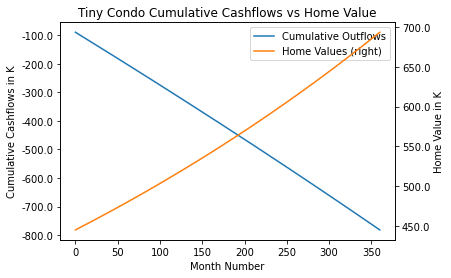

In [28]:
first_condo_df["Home Values"] = home_values
first_condo_df["Down Payments"] = down_payments


first_condo_df["Total Outflows"] = (
    first_condo_df["Principal Payments"]
    + first_condo_df["Interest Payments"]
    + first_condo_df["Taxes and Insurance"]
    #     + first_condo_df["HOA Payments"]
    + first_condo_df["Down Payments"]
)
first_condo_df["Cumulative Outflows"] = first_condo_df["Total Outflows"].cumsum()
plt.figure()
ax = first_condo_df[["Cumulative Outflows", "Home Values"]].plot(
    secondary_y=["Home Values"]
)
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.right_ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

ax.set_ylabel("Cumulative Cashflows in K")
ax.set_xlabel(month_number_label)
ax.set_title("Tiny Condo Cumulative Cashflows vs Home Value")
ax.right_ax.set_ylabel("Home Value in K")

In [29]:
first_condo_df.tail()

,HOA Payments,Taxes and Insurance,Principal Payments,Interest Payments,Home Values,Down Payments,Total Outflows,Cumulative Outflows
356,-536,-592.350322,-1427.792426,-16.135110,690041.605060,0.0,-2036.277857,-773848.976061
357,-536,-593.080690,-1431.004959,-12.922577,690892.426359,0.0,-2037.008225,-775885.984287
358,-536,-593.811958,-1434.224720,-9.702815,691744.296720,0.0,-2037.739494,-777923.723780
359,-536,-594.544128,-1437.451726,-6.475810,692597.217438,0.0,-2038.471664,-779962.195444
360,-536,-595.277201,-1440.685992,-3.241543,693451.189807,0.0,-2039.204737,-782001.400181


In [30]:
(
    first_condo_df.loc[12 * years_to_model]["Home Values"]
    + first_condo_df.loc[12 * years_to_model]["Cumulative Outflows"]
)

-88550.21037340886

At the end of 30 years, we have paid over a million dollars for this 683sqft condo, _*and it still costs 1400/month in HOA, tax, and insurance*_!  And remember, we didn't include any inflation here; all that home value increase came from real appreciation.  If appreciation is lower than this very rosy forecast, we are upside down on the transaction.

But surely this is better than renting, right?  Well, remember that when renting we get to _invest_ the down payment.  So let's fix the original example to include that.

<Figure size 432x288 with 0 Axes>

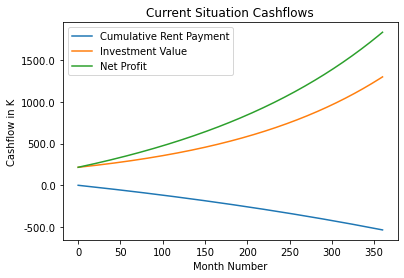

In [25]:
title = "Current Situation"
rent = -1100
rents = [0]
principal = home_value * (pct_down) / 100
annual_stock_appreciation_pct = 6
monthly_stock_appreciation_pct = annual_stock_appreciation_pct / 12
principals = [principal]
for year in range(years_to_model):
    for month in range(12):
        rents.append(rent)
        principal *= 1 + monthly_stock_appreciation_pct / 100
        principals.append(principal)
    rent *= 1 + rent_increase_per_year_pct / 100


plt.figure()

current_df = pd.DataFrame({"Monthly Rent": rents, "Investment Value": principals})
current_df["Cumulative Rent Payment"] = current_df["Monthly Rent"].cumsum()
current_df["Net Profit"] = (
    current_df["Investment Value"] - current_df["Cumulative Rent Payment"]
)
ax = current_df[["Cumulative Rent Payment", "Investment Value", "Net Profit"]].plot(
    xlabel=month_number_label, ylabel="Cashflow in K", title=f"{title} Cashflows"
)
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

In [1]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>